In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# trained_model_dir = "backup_trained_models/"
trained_model_dir = "results/"

template = "cifar10/UntrainedResNet34OAT-2BN/{}_e30-b100_sgd-lr0.1-m0.9-wd0.0005_cos_disc-ew-[0.0, 0.1, 0.2, 0.3, 0.4, 1.0]-rand-d128/eval/{}.txt"

def get_robust_accuracy(test_adversarial):
    train_adversarial = "original"
    path = trained_model_dir + template.format("original", test_adversarial)
    file = open(path)
    acc = file.readlines()[-2]
    file.close()
    robust_acc = float(acc.split()[-1])
    
    return robust_acc

def get_trained_robust_accuracy(train_adversarial):
    path = trained_model_dir + template.format(train_adversarial, train_adversarial)
    file = open(path)
    acc = file.readlines()[-2]
    file.close()
    trained_robust_acc = float(acc.split()[-1])
    
    return trained_robust_acc

def get_cross_robust_accuracy(train_adversarial, test_adversarial):
    path = trained_model_dir + template.format(train_adversarial, test_adversarial)
    file = open(path)
    acc = file.readlines()[-2]
    file.close()
    cross_robust_acc = float(acc.split()[-1])
    
    return cross_robust_acc

In [28]:
train = "autoattack"
test = "cw"

trained_robust_accuracy = get_trained_robust_accuracy(train)
cross_robust_accuracy = get_cross_robust_accuracy(train, test)

print("Train Data: ", train)
print("Test Data: ", test)
print("=================")
print("Trained Robust Accuracy: ", trained_robust_accuracy)
print("Cross Robust Accuracy: ", cross_robust_accuracy)

Train Data:  autoattack
Test Data:  cw
Trained Robust Accuracy:  0.8674
Cross Robust Accuracy:  0.8931


In [29]:
train = "cw"
test = "autoattack"

trained_robust_accuracy = get_trained_robust_accuracy(train)
cross_robust_accuracy = get_cross_robust_accuracy(train, test)

print("Train Data: ", train)
print("Test Data: ", test)
print("=================")
print("Trained Robust Accuracy: ", trained_robust_accuracy)
print("Cross Robust Accuracy: ", cross_robust_accuracy)

Train Data:  cw
Test Data:  autoattack
Trained Robust Accuracy:  0.8926
Cross Robust Accuracy:  0.821


In [30]:
def robust_accuracies(attacks) :
    accs = []
    names = []
    for a in attacks :
        accs.append(get_robust_accuracy(a))
        names.append(a)
    return accs, names

def trained_robust_accuracies(attacks) :
    accs = []
    names = []
    for a in attacks :
        accs.append(get_trained_robust_accuracy(a))
        names.append(a)
    return accs, names    

In [31]:
TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "squareattack", "deepfool", "newtonfool", "pixelattack", "spatialtransformation"]

attacks = TOOLBOX_ADV_ATTACK_LIST

In [32]:
robust_accs, names = robust_accuracies(attacks)
trained_robust_accs, names = trained_robust_accuracies(attacks)

In [33]:
robust_accs

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.098, 0.1, 0.1, 0.1, 0.1]

In [34]:
trained_robust_accs

[0.8674,
 0.8591,
 0.8529,
 0.8926,
 0.8016,
 0.8467,
 0.9122,
 0.8813,
 0.8818,
 0.8967,
 0.865]

In [35]:
names

['autoattack',
 'autopgd',
 'bim',
 'cw',
 'fgsm',
 'pgd',
 'squareattack',
 'deepfool',
 'newtonfool',
 'pixelattack',
 'spatialtransformation']

In [36]:
df = pd.DataFrame(data={"attack": names, "robust_accuracy": robust_accs, "trained_robust_accuracy": trained_robust_accs})

In [37]:
df["improvement"] = df["trained_robust_accuracy"] - df["robust_accuracy"]

In [38]:
df

,attack,robust_accuracy,trained_robust_accuracy,improvement
0,autoattack,0.100,0.8674,0.7674
1,autopgd,0.100,0.8591,0.7591
2,bim,0.100,0.8529,0.7529
3,cw,0.100,0.8926,0.7926
4,fgsm,0.100,0.8016,0.7016
5,pgd,0.100,0.8467,0.7467
6,squareattack,0.098,0.9122,0.8142
7,deepfool,0.100,0.8813,0.7813
8,newtonfool,0.100,0.8818,0.7818
9,pixelattack,0.100,0.8967,0.7967


$A(M, X_B)$ = robust_accuracy

$A(M_B, X_B)$ = trained_robust_accuracy

$A(M_B, X_C)$ = cross_robust_accuracy

## RQ1 - Motivating work

We hypothesize that each adversarial attack has a unique characteristic, thus the test cases generated from each adversarial attack are not targeting the same bug. To prove if the accuracy is not enough in measuring the performance of adversarial attacks, we need to demonstrate that $bugs_{X_C} \nsubseteq bugs_{X_B}$ and $bugs_{X_B} \nsubseteq bugs_{X_C}$. In the other word, there exist at least 2 adversarial examples $X_B$ and $X_C$ such that $A(M_C, X_B) < A(M_B, X_B)$ and $A(M_B, X_C) < A(M_C, X_C)$.

In [39]:
def compare(a1, a2):
    trained_robust_acc = get_trained_robust_accuracy(a1) 
    cross_robust_acc = get_cross_robust_accuracy(a2, a1)
#     print("Trained Robust Accuracy: ", trained_robust_acc)
#     print("Cross Robust Accuracy: ", cross_robust_acc)
    return trained_robust_acc - cross_robust_acc

In [40]:
def get_comparison_metrics(attacks) :
    metrics = {}
    for a1 in attacks :
        m = {}
        for a2 in attacks :
            m[a2] = compare(a1, a2)
        metrics[a1] = m  
    return metrics
    
def plot_heatmap(metrics, fpath, vmin, vmax, annot): 

    df = pd.DataFrame(data=metrics)

    plt.figure(figsize=(10,5))
    fig = sns.heatmap(df, cmap="coolwarm", vmin=vmin, vmax=vmax, annot=annot, linewidth=0.7)
    fig.set(xlabel='Train', ylabel='Test')
    fig.figure.savefig(fpath)
    plt.show()

In [41]:
metrics = get_comparison_metrics(attacks)

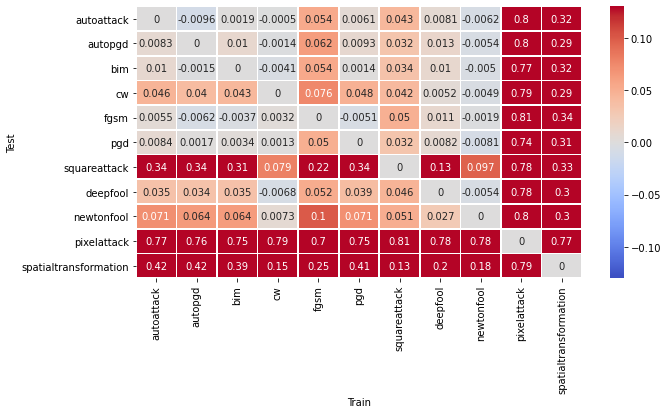

In [44]:
plot_heatmap(metrics, "plot/rq1.png", vmin=-0.13, vmax=0.13, annot=True)

$A(M_B, X_C) < A(M_C, X_C)$ is satisfied when $A(M_C, X_C) - A(M_B, X_C) > 0$. In the heatmap above, the value represent the difference between $A(M_C, X_C)$ and $A(M_B, X_C)$. We can see that several heatmaps have the red-like color which prove that this happen.

For an example, if we take SpatialTransformation and PixelAttack then we get

    
* $A(M'_{SpatialTransformation}, X'_{PixelAttack}) - A(M'_{PixelAttack}, X'_{PixelAttack})$ = 0.65
* $A(M'_{PixelAttack}, X'_{SpatialTranformation}) - A(M'_{SpatialTranformation}, X'_{SpatialTranformation})$ = 0.53


It proves that SpatialTransformation has test cases that are attacking different bugs from any test cases in PixelAttack and vice versa. From this heatmap, we get 26 pairs of adversarial attacks that satisfy $A(M'_2, X'_2) - A(M'_1, X'_2) > 0$ and $A(M'_1, X'_1) - A(M'_2, X'_1) > 0$. 

In [45]:
# Make Sure
train = "spatialtransformation"
test = "pixelattack"

trained_robust_accuracy = get_trained_robust_accuracy(train)
cross_robust_accuracy = get_cross_robust_accuracy(test, train)

print("Train Data: ", train)
print("Test Data: ", test)
print("=================")
print("Trained Robust Accuracy: ", trained_robust_accuracy)
print("Cross Robust Accuracy: ", cross_robust_accuracy)

Train Data:  spatialtransformation
Test Data:  pixelattack
Trained Robust Accuracy:  0.865
Cross Robust Accuracy:  0.1


$A(M'_{SpatialTransformation}, X'_{PixelAttack}) - A(M'_{PixelAttack}, X'_{PixelAttack})$ = 0.7551 - 0.1 = 0.65

In [46]:
proof = set()
for a1 in attacks : 
    for a2 in attacks :
        if metrics[a1][a2] > 0 and metrics[a2][a1] > 0 :
            if a1 > a2 :
                proof.add(a1 + "-" + a2)
            else :
                proof.add(a2 + "-" + a1)
# len(proof)
# proof

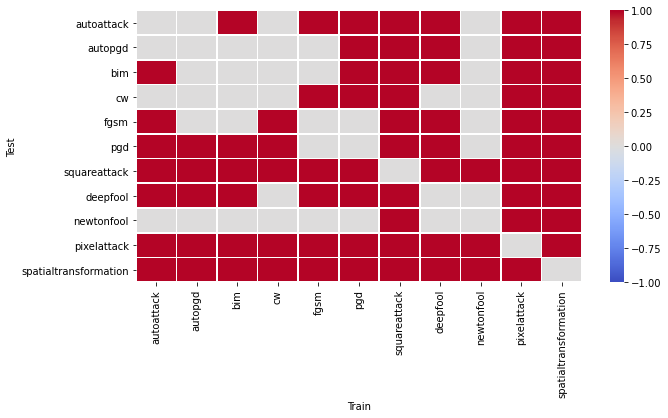

In [47]:
different_bugs_metrics = {}


for a1 in attacks : 
    sm = {}
    for a2 in attacks :
        id = a1 + "-" + a2 
        if a1 + "-" + a2  in proof or a2 + "-" + a1 in proof :
            sm[a2] = 1
        else :
            sm[a2] = 0
    different_bugs_metrics[a1] = sm
            
# len(proof)
# proof
plot_heatmap(different_bugs_metrics, "plot/rq1-different-bugs.png", vmin=-1, vmax=1, annot=False)

In the contrary, the AutoAttack, AutoPGD, BIM, CW , FGSM, and PGD, both have a 0 value. The test cases generated from those adversarial attacks don't attack the different bugs. we know that $bugs_{X_B} \subset bugs_{X_C}$ is satisfied if $A(M_C, X_B) > A(M_B, X_B)$ and $A(M_B, X_C) < A(M_C, X_C)$.

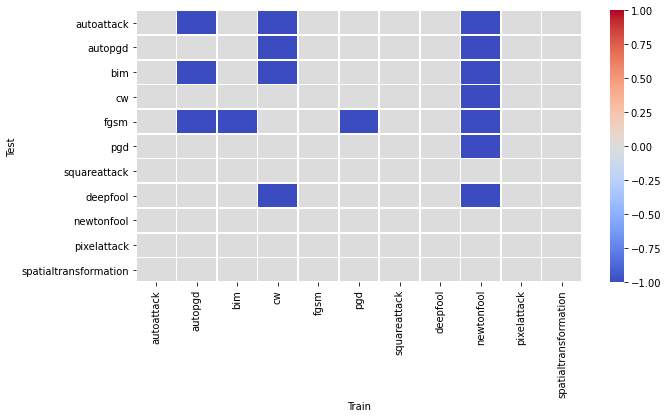

In [48]:
subset_bugs_metrics = {}

for a1 in attacks : 
    sm = {}
    for a2 in attacks :
        id = a1 + "-" + a2 
        if metrics[a1][a2] < 0 and metrics[a2][a1] > 0 :
            sm[a2] = -1
        else :
            sm[a2] = 0
    subset_bugs_metrics[a1] = sm

plot_heatmap(subset_bugs_metrics, "plot/rq1-subset-bugs.png", vmin=-1, vmax=1, annot=False)

In the Figure above, the horisontal axis means the first term used and the vertical axis is the second term used. For example, from the above metric, $bugs_{X_{AutoPGD}} \subset bugs_{X_{AutoAttack}}$, $bugs_{X_{FGSM}} \subset bugs_{X_{PGD}}$, $bugs_{X_{DeepFool}} \subset bugs_{X_{NewtonFool}}$, etc.

## RQ2 - How to use BSEM? How BSEM compared to the existing metric?

Given a model $M$, an original data $X$, a list of $n$ adversarial attack $AA = \{ aa_1, aa_2, aa_3, ... , aa_n \}$, an adversarial defense technique $AD$. First, we generate adversarial examples using each adversarial attack from $AA$. For each pair of adversarial examples generated from different adversarial attack, we measure BSEM. Then we make a leaderboard that mimic the existing evaluation relative to the adversarial defense $AD$.

In [53]:
def one_pov_relation(a1, a2):
    robust_acc = get_robust_accuracy(a2)
    trained_robust_acc = get_trained_robust_accuracy(a1)
    cross_robust_acc = get_cross_robust_accuracy(a2, a1)
#     print("Robust Accuracy: ", robust_acc)
#     print("Trained Robust Accuracy: ", trained_robust_acc)
#     print("Cross Robust Accuracy: ", cross_robust_acc)
    return (min(cross_robust_acc, trained_robust_acc) - robust_acc) / (trained_robust_acc - robust_acc)

def measure_relation(a1, a2) :
#     print((one_pov_relation(a1, a2) + one_pov_relation(a2, a1))/2)
    return max(0, (one_pov_relation(a1, a2) + one_pov_relation(a2, a1))/2)
#     return max(0, one_pov_relation(a1, a2))
#     return max(0, one_pov_relation(a2, a1))
    

In [54]:
# measure_relation("spatialtransformation", "ffgsm")
measure_relation("pgd", "autoattack")

0.99044233511998

In [55]:
def plot_relation_heatmap(attacks):
    metrics = {}
    for a1 in attacks :
        m = {}
        for a2 in attacks :
            m[a2] = measure_relation(a1, a2)
        metrics[a1] = m    

    df = pd.DataFrame(data=metrics)

    plt.figure(figsize=(10,5))
    fig = sns.heatmap(df, cmap="coolwarm", vmax=1, vmin=0, annot=True, linewidth=0.7)
    fig.set(xlabel='Train', ylabel='Test')
    fig.figure.savefig("plot/rq2.png")
    plt.show()
    
    #TODO: 
    # cek formula -> what does it means?
    # benerin angka dibelakakgn koma
    # 

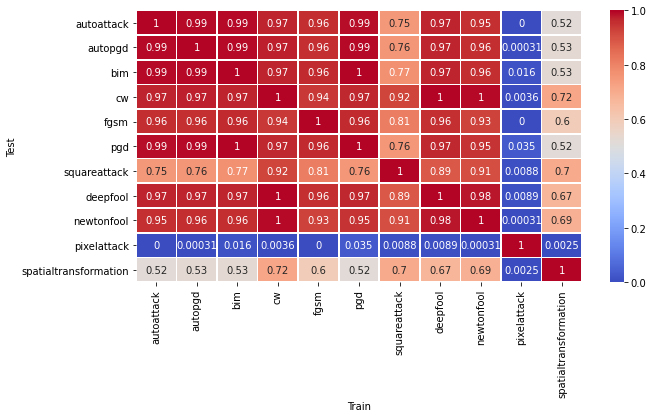

In [56]:
plot_relation_heatmap(attacks)

In [57]:
leaderboard = df[["attack","robust_accuracy"]]
leaderboard.sort_values(["robust_accuracy"]).reset_index(drop=True)

,attack,robust_accuracy
0,squareattack,0.098
1,autoattack,0.100
2,autopgd,0.100
3,bim,0.100
4,cw,0.100
5,fgsm,0.100
6,pgd,0.100
7,deepfool,0.100
8,newtonfool,0.100
9,pixelattack,0.100


From the leaderboard, AutoAttack is the best one. But it seems that MIFGSM are attacking the different bugs from the others. None of attacks are looks similar with MIFGSM. Compared to TPGD, the BSEM value is 0 means they are totally attacking different bugs. 